# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [25]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util

In [26]:
today = datetime.date.today()
tomorrow = today + datetime.timedelta(days = 1)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [27]:
project = hopsworks.login()
conn = hopsworks.connection()
fs = project.get_feature_store() 

location_str = conn.get_secrets_api().get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']
print(location_str)

Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.
{"country": "sweden", "city": "stockholm", "street": "stockholm-hornsgatan-108-gata"}


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [28]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [29]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [30]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.5450603E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [31]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

f = weather_fg.read()

Finished: Reading data from Hopsworks, using ArrowFlight (0.36s) 


In [32]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
a = air_quality_fg.read()
a = a.sort_values(by=['date'])
a

Finished: Reading data from Hopsworks, using ArrowFlight (0.44s) 


,date,pm25,country,city,street
1465,2017-10-04 00:00:00+00:00,13.0,sweden,stockholm,stockholm-hornsgatan-108-gata
1076,2017-10-05 00:00:00+00:00,9.0,sweden,stockholm,stockholm-hornsgatan-108-gata
1917,2017-10-06 00:00:00+00:00,8.0,sweden,stockholm,stockholm-hornsgatan-108-gata
1941,2017-10-07 00:00:00+00:00,13.0,sweden,stockholm,stockholm-hornsgatan-108-gata
1355,2017-10-08 00:00:00+00:00,8.0,sweden,stockholm,stockholm-hornsgatan-108-gata
...,...,...,...,...,...
2276,2024-03-12 00:00:00+00:00,46.0,sweden,stockholm,stockholm-hornsgatan-108-gata
2277,2024-03-13 00:00:00+00:00,51.0,sweden,stockholm,stockholm-hornsgatan-108-gata
2278,2024-03-14 00:00:00+00:00,41.0,sweden,stockholm,stockholm-hornsgatan-108-gata
2279,2024-03-15 00:00:00+00:00,54.0,sweden,stockholm,stockholm-hornsgatan-108-gata


In [33]:
batch_data = f[f['date'] > str(today)]
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
2356,2024-03-17 00:00:00+00:00,1.35,0.0,24.138800,17.354122,stockholm
2357,2024-03-18 00:00:00+00:00,0.85,0.0,9.085988,56.309898,stockholm
2358,2024-03-19 00:00:00+00:00,3.80,0.0,1.835647,191.309891,stockholm
2359,2024-03-20 00:00:00+00:00,6.05,0.0,12.864649,197.928009,stockholm
2360,2024-03-21 00:00:00+00:00,4.25,0.0,11.901798,183.468155,stockholm
2361,2024-03-22 00:00:00+00:00,5.15,0.1,21.566975,194.500198,stockholm
2362,2024-03-23 00:00:00+00:00,6.10,0.1,17.102840,229.267975,stockholm
2363,2024-03-24 00:00:00+00:00,4.85,0.0,8.707237,209.744797,stockholm
2364,2024-03-25 00:00:00+00:00,1.10,0.1,17.771753,353.019043,stockholm


In [34]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 2356 to 2364
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
dtypes: datetime64[us, UTC](1), float32(4), object(1)
memory usage: 360.0+ bytes


In [35]:
# batch_data = feature_view.get_batch_data(start_time=tomorrow, event_time=True, primary_key=True)
# pred_df = batch_data.drop(columns=['date'])
# print(feature_view.query.to_string())

### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [36]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
2356,2024-03-17 00:00:00+00:00,1.35,0.0,24.138800,17.354122,stockholm,12.122727
2357,2024-03-18 00:00:00+00:00,0.85,0.0,9.085988,56.309898,stockholm,35.508118
2358,2024-03-19 00:00:00+00:00,3.80,0.0,1.835647,191.309891,stockholm,47.807198
2359,2024-03-20 00:00:00+00:00,6.05,0.0,12.864649,197.928009,stockholm,38.513573
2360,2024-03-21 00:00:00+00:00,4.25,0.0,11.901798,183.468155,stockholm,36.063000
2361,2024-03-22 00:00:00+00:00,5.15,0.1,21.566975,194.500198,stockholm,40.226952
2362,2024-03-23 00:00:00+00:00,6.10,0.1,17.102840,229.267975,stockholm,24.637451
2363,2024-03-24 00:00:00+00:00,4.85,0.0,8.707237,209.744797,stockholm,28.361113
2364,2024-03-25 00:00:00+00:00,1.10,0.1,17.771753,353.019043,stockholm,18.812698


In [14]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 2356 to 2364
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   predicted_pm25               9 non-null      float32            
dtypes: datetime64[us, UTC](1), float32(5), object(1)
memory usage: 396.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [38]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
2356,2024-03-17 00:00:00+00:00,1.35,0.0,24.138800,17.354122,stockholm,12.122727,stockholm-hornsgatan-108-gata,sweden,1
2357,2024-03-18 00:00:00+00:00,0.85,0.0,9.085988,56.309898,stockholm,35.508118,stockholm-hornsgatan-108-gata,sweden,2
2358,2024-03-19 00:00:00+00:00,3.80,0.0,1.835647,191.309891,stockholm,47.807198,stockholm-hornsgatan-108-gata,sweden,3
2359,2024-03-20 00:00:00+00:00,6.05,0.0,12.864649,197.928009,stockholm,38.513573,stockholm-hornsgatan-108-gata,sweden,4
2360,2024-03-21 00:00:00+00:00,4.25,0.0,11.901798,183.468155,stockholm,36.063000,stockholm-hornsgatan-108-gata,sweden,5
2361,2024-03-22 00:00:00+00:00,5.15,0.1,21.566975,194.500198,stockholm,40.226952,stockholm-hornsgatan-108-gata,sweden,6
2362,2024-03-23 00:00:00+00:00,6.10,0.1,17.102840,229.267975,stockholm,24.637451,stockholm-hornsgatan-108-gata,sweden,7
2363,2024-03-24 00:00:00+00:00,4.85,0.0,8.707237,209.744797,stockholm,28.361113,stockholm-hornsgatan-108-gata,sweden,8
2364,2024-03-25 00:00:00+00:00,1.10,0.1,17.771753,353.019043,stockholm,18.812698,stockholm-hornsgatan-108-gata,sweden,9


In [17]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 2356 to 2364
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   predicted_pm25               9 non-null      float32            
 7   street                       9 non-null      object             
 8   country                      9 non-null      object             
 9   days_before_forecast_day     9 non-null      int64              
dtypes: datetime64[us, UTC](1), float32(5), int64(1), obje

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

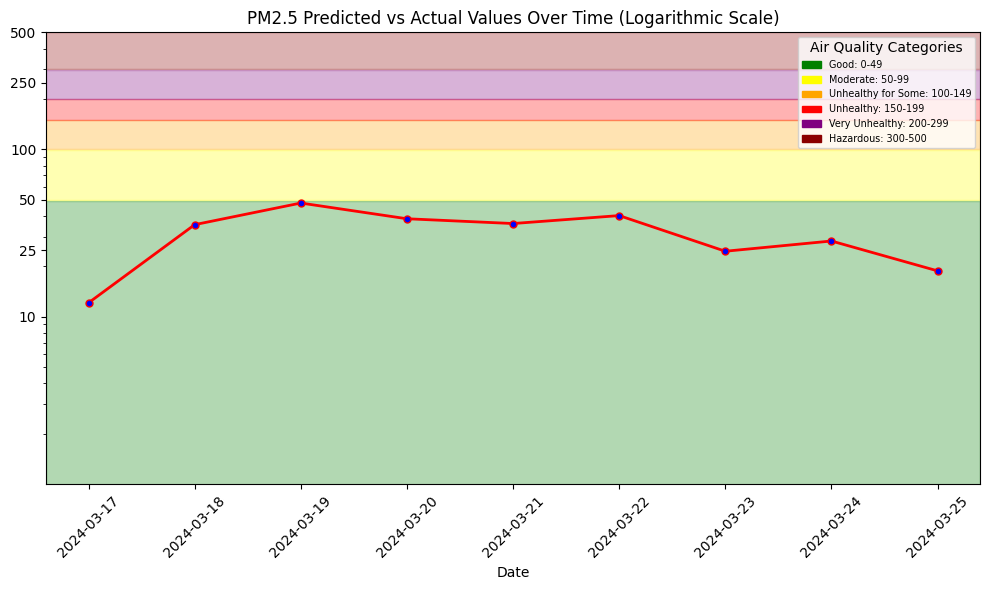

In [18]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(batch_data, file_path)
plt.show()

In [19]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_monitoring',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['country','street','date', 'days_before_forecast_day'],
    event_time="date"
)

In [19]:
monitor_fg.insert(batch_data, wait=True)

Feature Group created successfully, explore it at 
https://snurran.hops.works/p/8321/fs/8269/fg/9309


Uploading Dataframe: 0.00% |          | Rows 0/10 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_monitoring_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://snurran.hops.works/p/8321/jobs/named/aq_monitoring_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7fc682586410>, None)

In [20]:
from hsfs.feature import Feature

# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(Feature("days_before_forecast_day") == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using ArrowFlight (0.47s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-03-09 00:00:00+00:00,0.7,0.0,10.495713,59.036320,stockholm,35.458157,stockholm-hornsgatan-108-gata,sweden,1
1,2024-03-10 00:00:00+00:00,0.5,0.0,15.790833,114.227737,stockholm,36.469070,stockholm-hornsgatan-108-gata,sweden,1
2,2024-03-11 00:00:00+00:00,3.5,0.0,12.224107,103.627014,stockholm,38.769756,stockholm-hornsgatan-108-gata,sweden,1
3,2024-03-12 00:00:00+00:00,5.4,0.0,7.903619,120.068497,stockholm,54.161850,stockholm-hornsgatan-108-gata,sweden,1
4,2024-03-13 00:00:00+00:00,3.4,0.0,9.793058,197.102814,stockholm,32.752457,stockholm-hornsgatan-108-gata,sweden,1
5,2024-03-16 00:00:00+00:00,8.8,0.1,11.525623,181.789871,stockholm,41.385178,stockholm-hornsgatan-108-gata,sweden,1


In [21]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using ArrowFlight (0.40s) 


,date,pm25,country,city,street
0,2017-10-18 00:00:00+00:00,10.0,sweden,stockholm,stockholm-hornsgatan-108-gata
1,2020-06-17 00:00:00+00:00,30.0,sweden,stockholm,stockholm-hornsgatan-108-gata
2,2023-04-12 00:00:00+00:00,62.0,sweden,stockholm,stockholm-hornsgatan-108-gata
3,2020-03-22 00:00:00+00:00,16.0,sweden,stockholm,stockholm-hornsgatan-108-gata
4,2018-11-11 00:00:00+00:00,57.0,sweden,stockholm,stockholm-hornsgatan-108-gata
...,...,...,...,...,...
2276,2024-03-12 00:00:00+00:00,46.0,sweden,stockholm,stockholm-hornsgatan-108-gata
2277,2024-03-13 00:00:00+00:00,51.0,sweden,stockholm,stockholm-hornsgatan-108-gata
2278,2024-03-14 00:00:00+00:00,41.0,sweden,stockholm,stockholm-hornsgatan-108-gata
2279,2024-03-15 00:00:00+00:00,54.0,sweden,stockholm,stockholm-hornsgatan-108-gata


In [23]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])
hindcast_df

,date,predicted_pm25,pm25
0,2024-03-09 00:00:00+00:00,35.458157,35.0
1,2024-03-10 00:00:00+00:00,36.469070,24.0
2,2024-03-11 00:00:00+00:00,38.769756,26.0
3,2024-03-12 00:00:00+00:00,54.161850,46.0
4,2024-03-13 00:00:00+00:00,32.752457,51.0
5,2024-03-16 00:00:00+00:00,41.385178,51.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

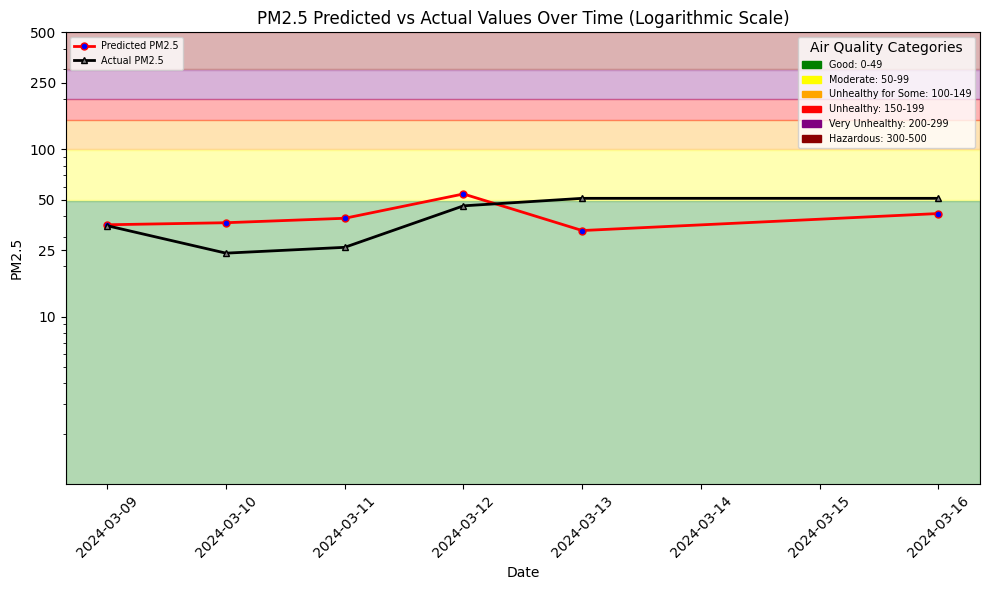

In [24]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---